In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Homework 6.2 - Neural Networks and Deep Learning

**Name**:

**Student Number**:

**Sources**:

An [AutoEncoder](https://en.wikipedia.org/wiki/Autoencoder#:~:text=An%20autoencoder%20is%20a%20type,to%20ignore%20signal%20%E2%80%9Cnoise%E2%80%9D.) (AE) is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. Despite their numerous applications their implemention and theoretical background is pretty straightforward. Throughout this assignment you will implement an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron)-based AE to reconstruction hand-written digits of [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. 

### Install & import the required packages
Install and import torch and torchvision (or any other package you think might come in handy).

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
%matplotlib inline



### 0. Load input data and preprocess (3 pt)
You're expected to use the MNIST dataset over the course of this assignment. After loading the train and test splits of the dataset, apply the required preprocessing procedures (zero center your input data). PyTorch provides convenient tools to automate this process.

In [3]:
batch_size = 100

train_dataset = torchvision.datasets.MNIST('/', train=True, 
                download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ]))

valid_dataset = torchvision.datasets.MNIST('/', train=True, 
                download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ]))

test_dataset = torchvision.datasets.MNIST('/', train=False, 
                download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ]))

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[10000:], indices[:10000]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=batch_size, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=batch_size, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                batch_size=batch_size, shuffle=True)

Extracting /MNIST/raw/train-images-idx3-ubyte.gz to /MNIST/raw


Extracting /MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST/raw


Extracting /MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST/raw


Extracting /MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 1.1. Implement an MLP based Autoencoder (17 pt)
The architecture of your network should be symmetrical and have 2 hidden layers of sizes $h_1$ and $h_2$ with a latant size of $l$ while using [$ReLU$](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))s as nonlinearities. The following picture depicts a sample AE architecture for $h_1=4$ and $h_2=3$ and $l=2$ for the reconstruction of $1\times5$ inputs.

<img src="./ae.png">

The input to the network will be a minibatch of data, of shape
$(N, 28*28)$ where $N$ represents batch size. 

    Inputs of the forwardpass:
    - A batch of flated images (N, 28*28)

    outputs of the forwardpass:
    - reconstruction: reconstruction of the images.

In [17]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=latent_dim)
        )

    def forward(self, img):
        x = self.model(img)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=256),
            nn.ReLU(inplace=True),            
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=28*28)
        )

    def forward(self, x):
        img = self.model(x)
        return img

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent = None
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        self.latent = z = self.encoder(x.view(x.size(0), -1))
        x_r = self.decoder(z)
        x_r = x_r.view(x_r.size(0), 28, 28)
        return x_r



### 1.2. Train the model (17 pt)
Set up a basic training loop for your network. Use a [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with no momentums to train your model. Use [L2](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions) as your objective function. Choose $N$ based on your available resources. (8 pt)

In [24]:
lr_max = 0.001
main_model = Autoencoder(latent_dim=5).cuda()
opt = torch.optim.Adam(main_model.parameters(), lr=lr_max)  # We use Adam instead of SGD for better performance
criterion = torch.nn.MSELoss()

train_loss = []
valid_loss = []

In [25]:
def train(model, epochs=20, print_log=False):
    model.train()
    global train_loss, valid_loss
    train_loss = []
    valid_loss = []
    #lr = lr_max
    #rem_epochs = 20
    for epoch in range(epochs):
        #rem_epochs -= 1
        #if rem_epochs==0:
        #    rem_epochs = 20
        #    lr = lr / 2
        #    opt.param_groups[0].update(lr=lr)

        cur_train_loss = 0
        for X, y in train_loader:
            X = X.reshape(batch_size, 28, 28).cuda()
            X_out = model(X)
            loss = criterion(X_out, X)
            opt.zero_grad()
            loss.backward()
            opt.step()
            cur_train_loss += loss.item()
        
        cur_valid_loss = 0
        for X, y in valid_loader:
            X = X.reshape(batch_size, 28, 28).cuda()
            X_out = model(X)
            loss = criterion(X_out, X)
            cur_valid_loss += loss.item()

        train_loss += [cur_train_loss/len(train_loader)]
        valid_loss += [cur_valid_loss/len(valid_loader)]
        if print_log:
            print("Epoch {}, Train Loss: {:.5f}, Validation Loss: {:.5f}".format(epoch,
                cur_train_loss/len(train_loader), cur_valid_loss/len(valid_loader)))

Train a model with $h_1=512$, $h_2=256$ and $l=5$, Train your model long enough so that you get the best results on the validation set. (2 pt)

In [26]:
train(main_model, print_log=True)

Epoch 0, Train Loss: 0.03737, Validation Loss: 0.03028
Epoch 1, Train Loss: 0.02885, Validation Loss: 0.02814
Epoch 2, Train Loss: 0.02712, Validation Loss: 0.02678
Epoch 3, Train Loss: 0.02607, Validation Loss: 0.02615
Epoch 4, Train Loss: 0.02538, Validation Loss: 0.02548
Epoch 5, Train Loss: 0.02478, Validation Loss: 0.02508
Epoch 6, Train Loss: 0.02430, Validation Loss: 0.02480
Epoch 7, Train Loss: 0.02392, Validation Loss: 0.02442
Epoch 8, Train Loss: 0.02358, Validation Loss: 0.02411
Epoch 9, Train Loss: 0.02330, Validation Loss: 0.02397
Epoch 10, Train Loss: 0.02306, Validation Loss: 0.02383
Epoch 11, Train Loss: 0.02284, Validation Loss: 0.02369
Epoch 12, Train Loss: 0.02263, Validation Loss: 0.02359
Epoch 13, Train Loss: 0.02248, Validation Loss: 0.02345
Epoch 14, Train Loss: 0.02229, Validation Loss: 0.02328
Epoch 15, Train Loss: 0.02216, Validation Loss: 0.02317
Epoch 16, Train Loss: 0.02204, Validation Loss: 0.02317
Epoch 17, Train Loss: 0.02192, Validation Loss: 0.02307
Ep

Plot the mean objective values for training and validation set on each epoch. (2 pt)

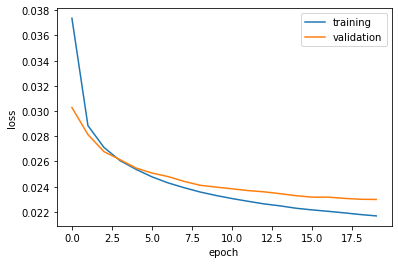

In [27]:
plt.plot(range(len(train_loss)), train_loss, label='training')
plt.plot(range(len(valid_loss)), valid_loss, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss') 
plt.legend()
plt.show()

Visualize the best and worst reconstructions of test split. (3 pt)

Best Loss:	0.00164
Worst Loss:	0.14030


<Figure size 432x288 with 0 Axes>

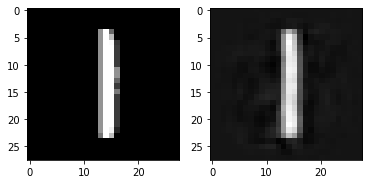

<Figure size 432x288 with 0 Axes>

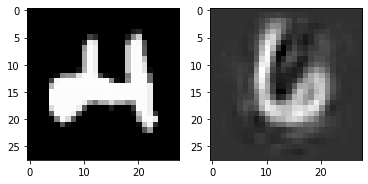

In [30]:
best_loss = -1
worst_loss = -1

for X, y in test_loader:
    X = X.reshape(batch_size, 28, 28).cuda()
    X_out = main_model(X)
    loss = torch.mean(nn.MSELoss(reduction='none')(X_out, X), dim=(1, 2))
    for i in range(len(loss)):
        if best_loss==-1 or best_loss>loss[i]:
            best_loss = loss[i].item()
            best_sample = X[i].cpu()
            best_sample_rec = X_out[i].cpu().detach()
        if worst_loss==-1 or worst_loss<loss[i]:
            worst_loss = loss[i].item()
            worst_sample = X[i].cpu()
            worst_sample_rec = X_out[i].cpu().detach()

print("Best Loss:\t{:.5f}".format(best_loss))
print("Worst Loss:\t{:.5f}".format(worst_loss))
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(best_sample, cmap='gray')
ax2.imshow(best_sample_rec, cmap='gray')
plt.show()
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(worst_sample, cmap='gray')
ax2.imshow(worst_sample_rec, cmap='gray')
plt.show()

Elaborate on how larger batchsizes can affect the training procedure and the final performance of the model? (2 pt)

**Answer:** Larger batchsize results in a faster training and has a regularization effect on the trained model. So it prevents model from overfitting and increases the performance on test data.

### 1.3. Investigation of different Latent sizes (14 pt)
By training your AE for $l=1$ to $l=7$ and visualizing the final train and validation reconstruction errors and sample outputs (for a fixed input), investigate the effects of lower and higher encoding latent spaces. (8 pt)

In [52]:
train_losses = []
valid_losses = []
models = []

max_l = 7

for l in range(max_l, 0, -1):
    model = Autoencoder(latent_dim=l).cuda()
    opt = torch.optim.Adam(model.parameters(), lr=lr_max)
    start_time = time.time()
    train(model)
    train_losses += [train_loss[-1]]
    valid_losses += [valid_loss[-1]]
    models += [model]
    print("l={}, Validation Loss: {:.5f}, Time: {:.2f} seconds".format(l, valid_loss[-1], time.time()-start_time))

train_losses.reverse()
valid_losses.reverse()
models.reverse()

l=7, Validation Loss: 0.01847, Time: 123.71 seconds
l=6, Validation Loss: 0.02028, Time: 124.60 seconds
l=5, Validation Loss: 0.02306, Time: 125.87 seconds
l=4, Validation Loss: 0.02631, Time: 125.83 seconds
l=3, Validation Loss: 0.03039, Time: 124.31 seconds
l=2, Validation Loss: 0.03632, Time: 125.58 seconds
l=1, Validation Loss: 0.04496, Time: 126.04 seconds


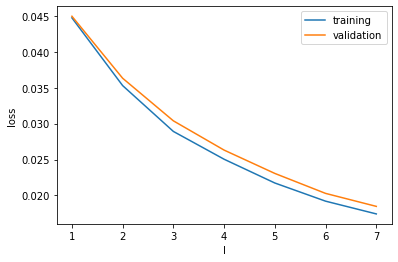

First column is real image, other columns are reconstructed ones with l=1 to l=7.



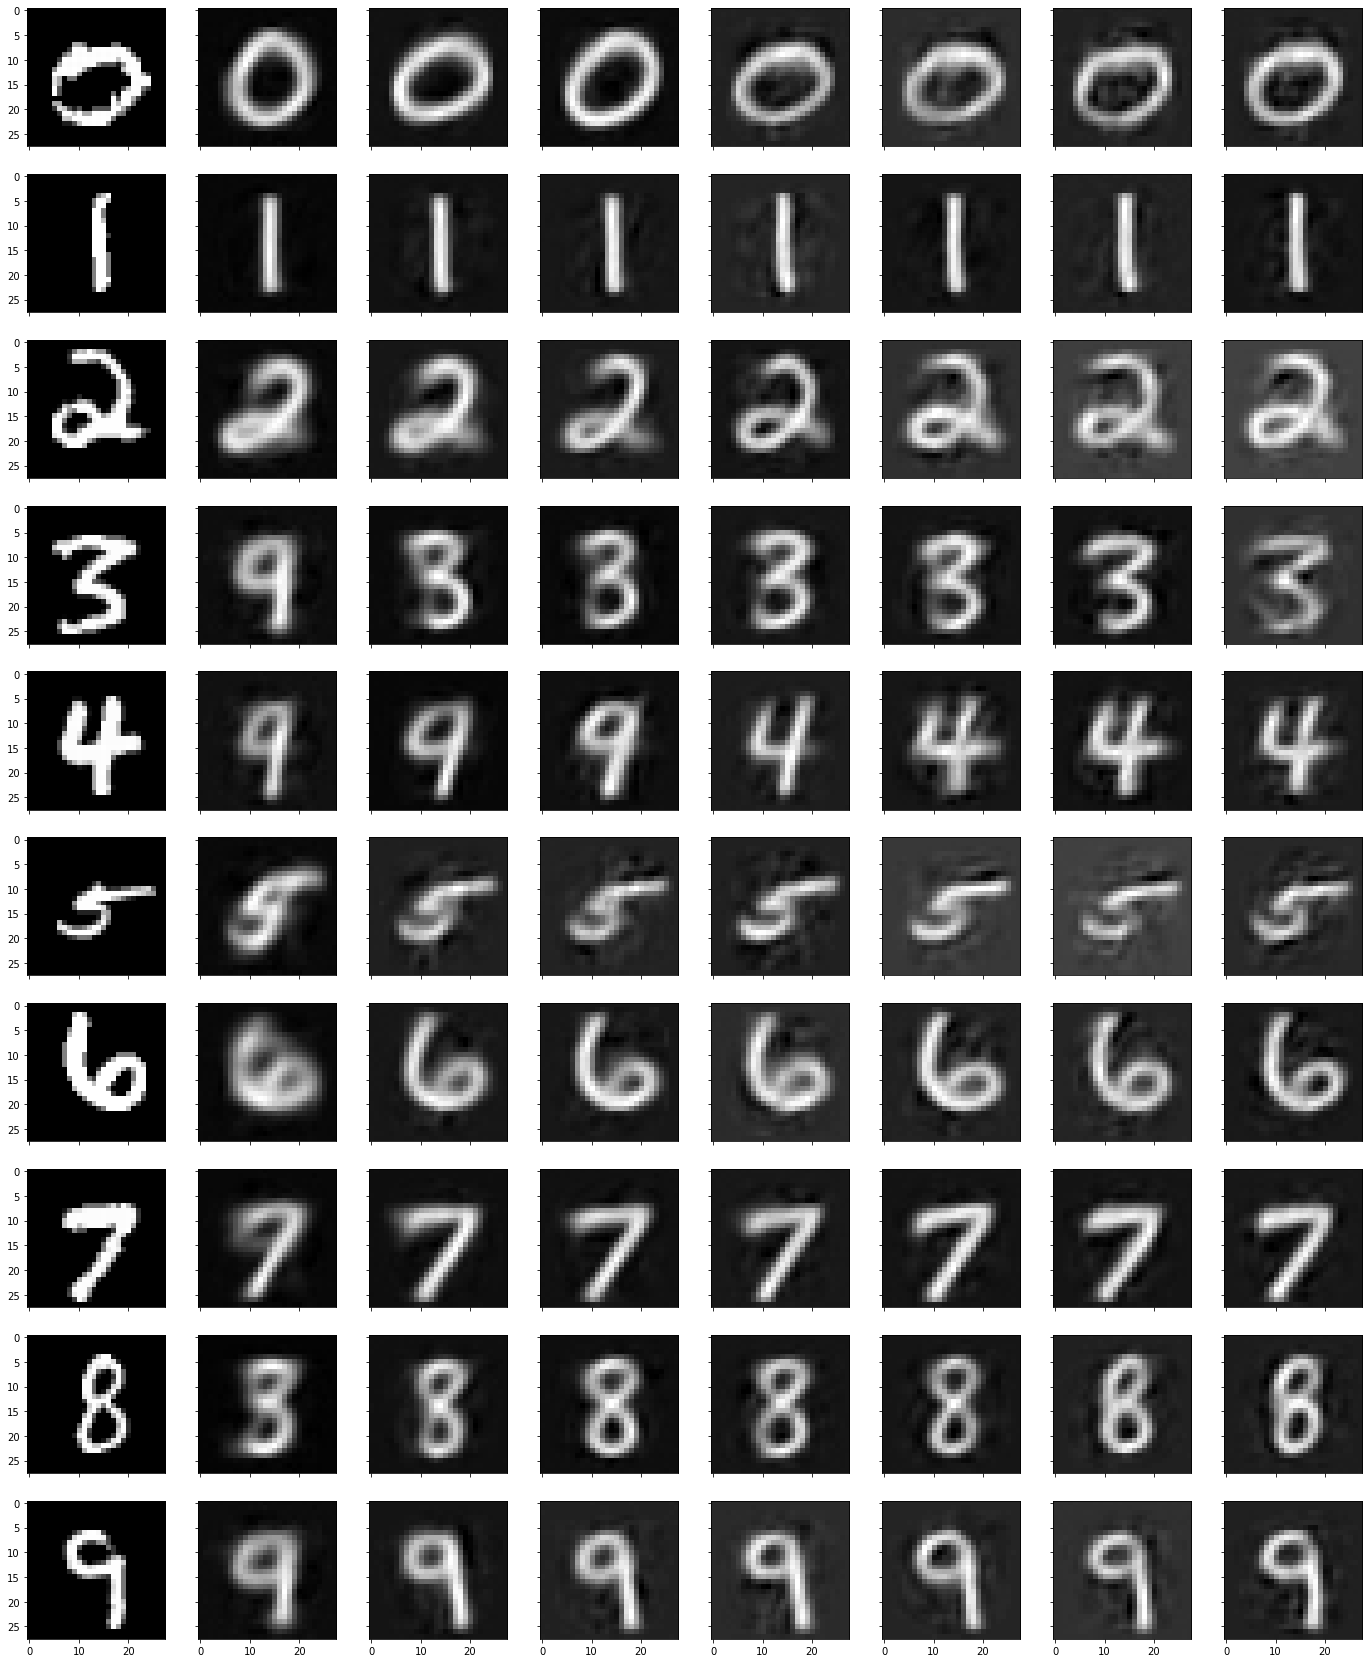

In [54]:
plt.figure()
plt.plot(range(1, max_l+1), train_losses, label='training')
plt.plot(range(1, max_l+1), valid_losses, label='validation')
plt.xlabel('l')
plt.ylabel('loss') 
plt.legend()
plt.show()

print("First column is real image, other columns are reconstructed ones with l=1 to l=7.\n")
fig, ax = plt.subplots(nrows=10, ncols=max_l+1, sharex=True, sharey=True)
fig.set_size_inches(3*(max_l+1), 3*10)
for idx in range(10):
  sample = None
  for X, y in test_loader:
      X = X.reshape(batch_size, 28, 28)
      for i in range(len(X)):
          if y[i]==idx:
              sample = X[i]
              break
      if sample!=None:
          break
  ax[idx,0].imshow(sample, cmap='gray')
  for jdx in range(1, max_l+1):
      sample_rec = models[jdx-1](sample.reshape(1, 28, 28).cuda()).detach().reshape(28, 28).cpu().detach()
      ax[idx,jdx].imshow(sample_rec, cmap='gray')


Elaborate on how the increase of the latent size of the AE will affect the quality of the reconstructed images and why? (3 pt)

**Answer:** As the latent size increases, model can learn more features to differentiant the inputs of different classes. So the average performance of the model would be better.

Elaborate on how the increase of the latent size of the AE will affect its training time? (3 pt)

**Answer:** Training time depends on size of network and number of its parameters. Most of parameteres of the autoencoder are between input layer and first hidden layer (28x28x512 parameters) and between last hidden layer and output layer. Increasing the latent size onyl increases number of parameteres by 2x256 and it is nothing compared to total number of parameters.

So increasing latent size doesn't affect training time that much and we consider the difference between runtimes to be due to random noise.

### 2. AE as a dimensionality reduction tool (14 pt)
Plot the respective latent vectors of the validation images after training an AE with $l=2$. (10 pt)

In [61]:
main_model = Autoencoder(latent_dim=2).cuda()
opt = torch.optim.Adam(main_model.parameters(), lr=lr_max)
train(main_model, epochs=50, print_log=True)

Epoch 0, Train Loss: 0.04885, Validation Loss: 0.04412
Epoch 1, Train Loss: 0.04242, Validation Loss: 0.04180
Epoch 2, Train Loss: 0.04050, Validation Loss: 0.04011
Epoch 3, Train Loss: 0.03930, Validation Loss: 0.03939
Epoch 4, Train Loss: 0.03849, Validation Loss: 0.03858
Epoch 5, Train Loss: 0.03788, Validation Loss: 0.03803
Epoch 6, Train Loss: 0.03752, Validation Loss: 0.03795
Epoch 7, Train Loss: 0.03709, Validation Loss: 0.03738
Epoch 8, Train Loss: 0.03678, Validation Loss: 0.03725
Epoch 9, Train Loss: 0.03648, Validation Loss: 0.03699
Epoch 10, Train Loss: 0.03623, Validation Loss: 0.03704
Epoch 11, Train Loss: 0.03612, Validation Loss: 0.03685
Epoch 12, Train Loss: 0.03586, Validation Loss: 0.03666
Epoch 13, Train Loss: 0.03573, Validation Loss: 0.03670
Epoch 14, Train Loss: 0.03557, Validation Loss: 0.03638
Epoch 15, Train Loss: 0.03536, Validation Loss: 0.03636
Epoch 16, Train Loss: 0.03526, Validation Loss: 0.03621
Epoch 17, Train Loss: 0.03523, Validation Loss: 0.03611
Ep

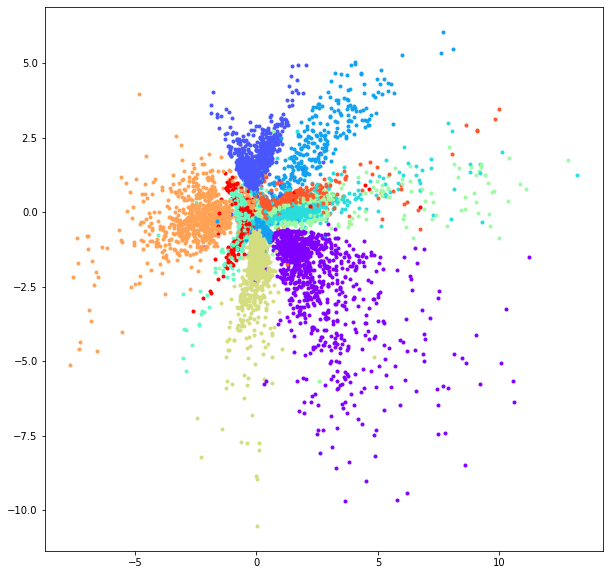

In [63]:
plt.figure(figsize=(10,10))
colors = cm.rainbow(np.linspace(0, 1, 10))
for X, y in valid_loader:
    X = X.reshape(batch_size, 28, 28).cuda()
    X_out = main_model(X)
    latent = main_model.latent.cpu().detach()
    for i in range(len(X)):
        plt.plot(latent[i][0], latent[i][1], marker='o', color=colors[y[i]], markersize=3)    
plt.show()

Elaborate on why you see what you see!? (2 pt)

**Answer:** Images from the same class have closer representations in latent space. The reason is that model used semantic features of the images to be able to compress them into a small vector and it's easier to distinguish samples by their latent vector for machine.

Describe how AEs can be used as a visualization tool (like PCA algorithm). (2 pt)

**Answer:** A visualization tool's job is to create a low dimensional representation of high dimensional data. If the output of visualization tool has 3 dimensions or less, it can be plotted and humans can understand propertise of the data by looking at it.

The other purpose of using visualization tools is that the compressed data is easier to save and requires less memory.

Autoencoders can create low dimensional representation of data so they can be used as a visualization tool too. Each feature in latent space of autoencoder has to be high level feature of training set images. Autoencoder has to learn these high level features so it can be able to reconstruct input images with the Decoder part.